In [2]:
# Import Dependencies and Styles

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
# More Dependencies

import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Data/hawaii.sqlite")

In [9]:
# Reflect an existing database into a new model

Base = automap_base()

# Reflect the tables

Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB

session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

aug_temps = calc_temps('2015-08-01', '2015-08-07')

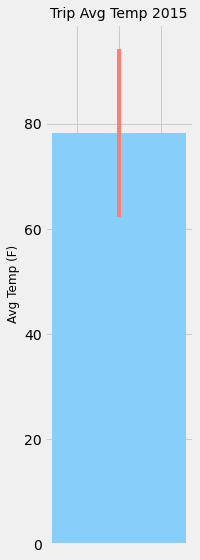

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Calling all values from method query above for plotting, set length of x_axis

avg_temp = aug_temps[0][1]
max_temp = aug_temps[0][2]
min_temp = aug_temps[0][0]

x_axis = len([avg_temp])

# Create plot for avg temp from data and create an error bar using the max and min values
# Plot aesthetics, hid x-axis labels

plt.figure(figsize = (3,8))
plt.bar([x_axis], [avg_temp], color = 'lightskyblue')
plt.errorbar([x_axis], [avg_temp], yerr = (max_temp - min_temp), color = 'salmon')
plt.title('Trip Avg Temp 2015', fontsize = 14)
plt.ylabel('Avg Temp (F)', fontsize = 12)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)

# Saving plot to output as png

output_image = f'Output/Avg_Temp_2015.png'
plt.tight_layout()
plt.savefig(output_image)

plt.show()

### Daily Rainfall Average

In [58]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

merged_query = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name,\
                             Station.latitude, Station.longitude, Station.elevation).\
                            filter(Measurement.station == Station.station).\
                            filter(Measurement.date >= '2015-08-01').\
                            filter(Measurement.date <= '2015-08-07').\
                            group_by(Measurement.station).\
                            order_by(func.sum(Measurement.prcp).desc()).all()

for row in merged_query:
    print(row)

(1.7500000000000002, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(0.6799999999999999, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(0.53, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(0.4, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(0.26, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(0.1, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(0.05, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [56]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [76]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d

date_list = []
curr_date = start_date
while str(curr_date) <= str(end_date):
    date_split = str(curr_date).split("-")
    date_list.append(f"{date_split[1]}-{date_split[2]}")
    curr_date = dt.date(int(date_split[0]), int(date_split[1]), int(date_split[2])) + dt.timedelta(days=1)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals_list = []
for date in date_list:
    normals = daily_normals(date)
    normals_list.append([normals[0][0], normals[0][1], normals[0][2]])

for row in normals_list:
    print(row)

[67.0, 75.54, 83.0]
[68.0, 75.60377358490567, 84.0]
[70.0, 76.61111111111111, 85.0]
[69.0, 76.71153846153847, 84.0]
[69.0, 76.14814814814815, 82.0]
[67.0, 76.25, 83.0]
[71.0, 77.15686274509804, 83.0]


In [79]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals_list, columns = ['Min Temp', 'Avg Temp', 'Max Temp'], index = date_list)
normals_df

,Min Temp,Avg Temp,Max Temp
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


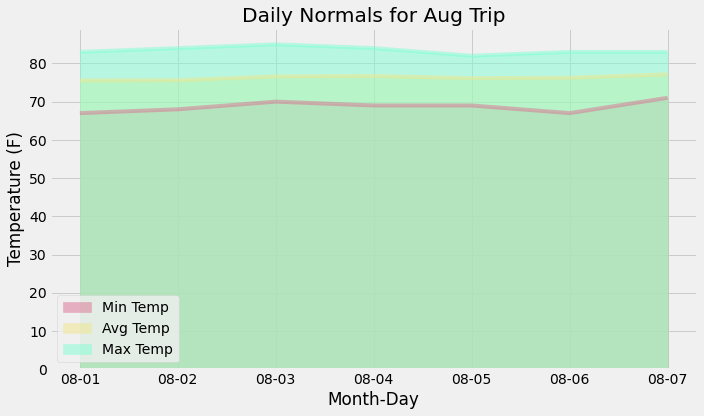

In [87]:
# Plot the daily normals as an area plot with `stacked=False`

colors = ['palevioletred', 'khaki', 'aquamarine']

normals_df.plot.area(stacked = False, color = colors, figsize = (10,6))

plt.title('Daily Normals for Aug Trip')
plt.xlabel('Month-Day')
plt.ylabel('Temperature (F)')

# Saving plot to output as png

output_image = f'Output/Daily_Normals.png'
plt.tight_layout()
plt.savefig(output_image)

plt.show()

## Close Session